To start we'll just load our dataset of noisy images to see what they look like

In [22]:
import pickle

noisy_images = pickle.load(open('noisy_images', 'rb')).numpy() / 255.0 # normalize pixels to 0-1
noisy_labels = pickle.load(open('noisy_labels', 'rb')).numpy()

print(noisy_images.shape)
print(noisy_labels.shape)

(60000, 28, 28)
(60000,)


Lets select 5 random images

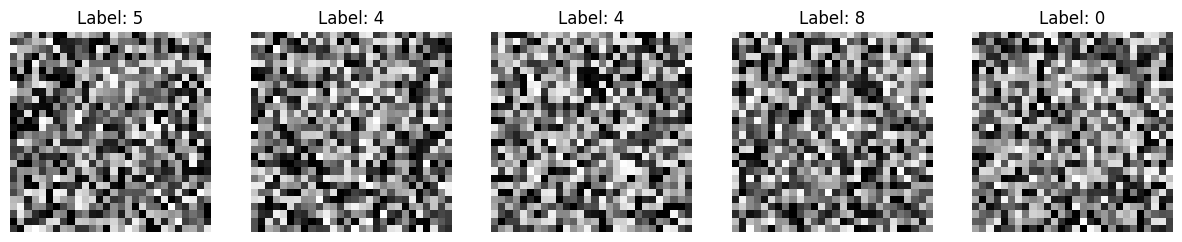

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_idxs = random.sample(range(len(noisy_images)), 5)
plt.figure(figsize=(15, 3))

for i, index in enumerate(random_idxs, 1):
    plt.subplot(1, 5, i)
    image = noisy_images[index]
    label = noisy_labels[index]

    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

It's clear that us humans cannot classify these images but lets see if we can train a neural net to do it for us

For a start lets see what happens if we use a standard CNN

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def get_model():
    inputs = layers.Input(shape=(28, 28, 1)) # images are 28x28 (see first cell)
    sizes = [16, 32]
    for size in sizes:
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(inputs if size==sizes[0] else x)
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    # x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x) # prevent overfitting
    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

Now that we have our model lest partition the datasets and train

In [23]:
import numpy as np

train_images = noisy_images[10000:]
train_labels = noisy_labels[10000:]

validation_images = noisy_images[5000:10000]
validation_labels = noisy_labels[5000:10000]

callbacks = [
  keras.callbacks.ModelCheckpoint("CNN_Model.h5", save_best_only=True, monitor="val_loss"),
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model = get_model()

model.fit(train_images, train_labels,
batch_size=256,
epochs=50,
validation_data=(validation_images, validation_labels),
callbacks=callbacks)

Epoch 1/50
196/196 [==============================] - 4s 15ms/step - loss: 2.3019 - accuracy: 0.1095 - val_loss: 2.3009 - val_accuracy: 0.1086
Epoch 2/50
 10/196 [>.............................] - ETA: 2s - loss: 2.3015 - accuracy: 0.1063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 2s 12ms/step - loss: 2.3015 - accuracy: 0.1121 - val_loss: 2.3004 - val_accuracy: 0.1086
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 2.3015 - accuracy: 0.1117 - val_loss: 2.3009 - val_accuracy: 0.1086
Epoch 4/50
196/196 [==============================] - 3s 13ms/step - loss: 2.3014 - accuracy: 0.1117 - val_loss: 2.3004 - val_accuracy: 0.1086
Epoch 5/50
196/196 [==============================] - 3s 13ms/step - loss: 2.2193 - accuracy: 0.1748 - val_loss: 2.0218 - val_accuracy: 0.2818
Epoch 6/50
196/196 [==============================] - 3s 14ms/step - loss: 1.9688 - accuracy: 0.3047 - val_loss: 1.7662 - val_accuracy: 0.3972
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 1.6659 - accuracy: 0.4246 - val_loss: 1.4578 - val_accuracy: 0.4922
Epoch 8/50
196/196 [==============================] - 3s 13ms/step - loss: 1.4987 - accuracy: 0.4896 - val_loss: 1.3873 - val_accuracy: 0.5290
Epoch 9/50

Now lets test our model on the test dataset

In [24]:
from tensorflow.keras.models import load_model

test_images = noisy_images[:5000]
test_labels = noisy_labels[:5000]

model = load_model('CNN_Model.h5')

results = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {results[1]}")

157/157 [==============================] - 1s 3ms/step - loss: 1.0330 - accuracy: 0.6454
Test Accuracy: 0.6453999876976013
